# Exercise of Chapter 2

In [65]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [54]:
HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [55]:
housing = load_housing_data()

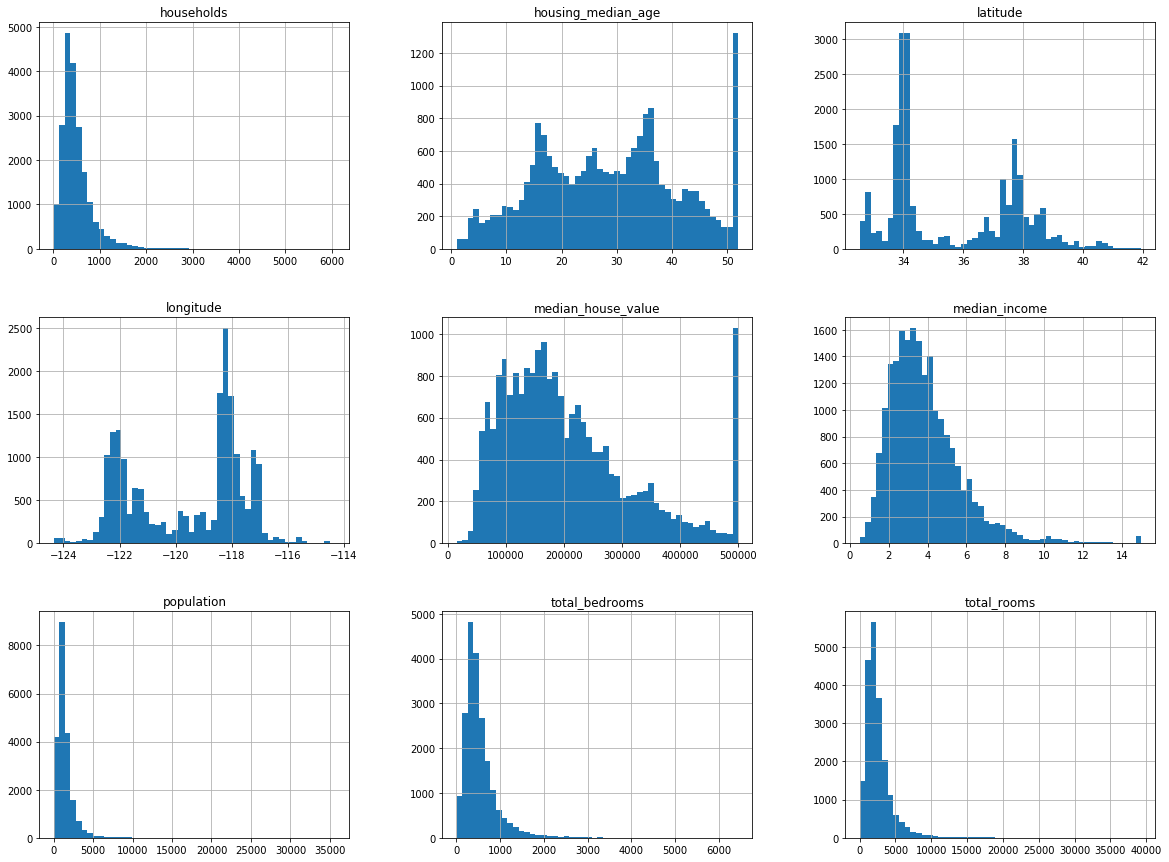

In [56]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Split Training and Test Set

In [57]:
housing['income_cat'] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [59]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [60]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Preparation Pipeline
    1. clean missing data
    2. handling categorical attributes
    3. build custom transformer
    4. feature scaling
    5. build transformation pipeline

In [61]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.preprocessing import FunctionTransformer

try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20    
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20
    
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [62]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

In [63]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('1hot_encoder', OneHotEncoder())
    ])

num_attribs = list(housing)
num_attribs.remove("ocean_proximity")
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [64]:
housing_prepared = full_pipeline.fit_transform(housing)

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Train Model

* default SVR

In [68]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svr = SVR()
svr.fit(housing_prepared, housing_labels)
housing_predictions = svr.predict(housing_prepared)

svr_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
svr_rmse

118577.43356412371

* GridSearchCV & linear kernel

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'kernel':['linear'], 'C':[64, 128]}]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

72530.59922838237 {'C': 64, 'kernel': 'linear'}
71333.0418428202 {'C': 128, 'kernel': 'linear'}


In [77]:
np.shape(housing_prepared)

(16512, 16)

* GridSearchCV & rbf kernel

In [79]:
param_grid = [{'kernel':['rbf'], 'C':[1, 10, 100, 1000, 10000], 'gamma': [0.1, 1, 10]}]
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

118688.70158708064 {'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}
118634.22435240951 {'C': 1, 'gamma': 0.0625, 'kernel': 'rbf'}
118651.94092284048 {'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}
118740.66401914001 {'C': 1, 'gamma': 0.25, 'kernel': 'rbf'}
118465.00705824536 {'C': 2, 'gamma': 0.03125, 'kernel': 'rbf'}
118356.51196411568 {'C': 2, 'gamma': 0.0625, 'kernel': 'rbf'}
118389.49822584912 {'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}
118565.31692813404 {'C': 2, 'gamma': 0.25, 'kernel': 'rbf'}
118018.12471782095 {'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}
117802.34181812892 {'C': 4, 'gamma': 0.0625, 'kernel': 'rbf'}
117857.46002969987 {'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}
118191.02170476543 {'C': 4, 'gamma': 0.25, 'kernel': 'rbf'}
117128.5157557084 {'C': 8, 'gamma': 0.03125, 'kernel': 'rbf'}
116707.20480912556 {'C': 8, 'gamma': 0.0625, 'kernel': 'rbf'}
116824.71606294464 {'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}
117487.20347184526 {'C': 8, 'gamma': 0.25, 'kernel': 'rbf'}
115349.1872984896

* RandomizedSearchCV (Takes some time)

In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon

svr = SVR()

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }
random_search = RandomizedSearchCV(svr, param_distributions = param_distribs, n_iter = 50, cv = 5, n_jobs = 4, 
                                   scoring = 'neg_mean_squared_error', return_train_score = True, verbose = 2, random_state = 42)

random_search.fit(housing_prepared, housing_labels)

cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.2s
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.2s
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.1s
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521,

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.8min


[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   8.0s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   8.0s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   8.3s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   5.9s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   5.8s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   5.7s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=  

[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=   8.1s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=   8.1s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=98.73897389920914, gamma=0.4960365360493639, kernel=rbf, total=   8.1s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=   8.1s
[CV] C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf ......
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=   8.1s
[CV] C=135.76775824842434, gamma=0.838636245624803, kernel=linear ....
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=   8.1s
[CV] C=135.76775824842434, gamma=0.838636245624803, kernel=linear ....
[CV]  C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf, total=   7.7s
[CV] C=135.767758

[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=   8.5s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=   8.4s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=   8.3s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=24547.601975705915, gamma=0.22153944050588595, kernel=rbf, total=   8.3s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=   8.0s
[CV] C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=   8.0s
[CV] C=16483.850529752886, gamma=1.4752145260435134, kernel=linear ...
[CV]  C=22.76927941060928, gamma=0.22169760231351215, kernel=rbf, total=   8.0s
[CV] C=164

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.6min


[CV]  C=16483.850529752886, gamma=1.4752145260435134, kernel=linear, total=   9.3s
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  39.0s
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  37.3s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  49.6s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  51.6s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  16.8s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  17.0s
[CV] C=56681.8085

[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=3582.0552780489566, gamma=1.1891370222133257, kernel=linear, total=   6.5s
[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=   5.7s
[CV] C=198.7004781812736, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=   5.7s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=   5.9s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=   5.9s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=198.7004781812736, gamma=0.5282819748826726, kernel=linear, total=   5.8s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=12

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 17.0min finished


70487.73975752539 {'C': 629.782329591372, 'gamma': 3.010121430917521, 'kernel': 'linear'}
65151.98496543675 {'C': 26290.206464300216, 'gamma': 0.9084469696321253, 'kernel': 'rbf'}
100293.08900577638 {'C': 84.14107900575871, 'gamma': 0.059838768608680676, 'kernel': 'rbf'}
70574.11375177321 {'C': 432.37884813148855, 'gamma': 0.15416196746656105, 'kernel': 'linear'}
118838.76739914888 {'C': 24.17508294611391, 'gamma': 3.503557475158312, 'kernel': 'rbf'}
70029.23360936904 {'C': 113564.03940586245, 'gamma': 0.0007790692366582295, 'kernel': 'rbf'}
107662.52814484686 {'C': 108.30488238805073, 'gamma': 0.3627537294604771, 'kernel': 'rbf'}
77562.95173075002 {'C': 21.344953672647435, 'gamma': 0.023332523598323388, 'kernel': 'linear'}
62578.76510141139 {'C': 5603.270317432516, 'gamma': 0.15023452872733867, 'kernel': 'rbf'}
54767.99053704408 {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}
70364.62759201857 {'C': 27652.464358739708, 'gamma': 0.2227358621286903, 'kernel': 'l

* best parameters

In [108]:
svr_best_params = random_search.best_params_
np.sqrt(-random_search.best_score_)

54767.99053704408

* important features by random forest regression

In [110]:
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [30], 'max_features': [8]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


49694.85143334442 {'max_features': 8, 'n_estimators': 30}


In [113]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

* build a full pipeline from preparation to prediction

In [109]:
prepare_predict_pipeline = Pipeline([('prepare', full_pipeline), ('svr', SVR(**svr_best_params))])
prepare_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('prepare', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder', Fu... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [102]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [222924.7316209  309050.82179703 202352.33313721  54463.21450967]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


* Add a transformer /in preparation pipeline to select the most important features

In [120]:
def feature_select(X, feature_importances, k):
    feature_indices = np.argpartition(feature_importances, -k)[-k:]
    return X[:, feature_indices]

In [133]:
# Use kw_args to pass arguments to callable func in FunctionTransformer
prepare_select_predict_pipeline = Pipeline([
    ('prepare', full_pipeline),
    ('select', FunctionTransformer(feature_select, kw_args = {'feature_importances':feature_importances, 'k':5}, validate = False)),
    ('svr', SVR(**svr_best_params))
])

In [138]:
from sklearn.model_selection import cross_val_score

prepare_select_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('prepare', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder', Fu... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [139]:
svr_5_scores = cross_val_score(prepare_select_predict_pipeline, housing, housing_labels, scoring="neg_mean_squared_error", cv=10)

svr_5_rmse = np.sqrt(-svr_5_scores)
print(svr_5_rmse)

[60445.43799273 58733.5331341  59723.4125333  62935.00921842
 60446.6561236  64875.60442799 57090.17821996 59691.48741831
 63294.65381405 61548.26424367]


* explore some preparation options in GridSearchCV

In [146]:
# test different imputer strategies and number of features
# how to make FunctionTransformer work with GridSearchCV : 
# https://stackoverflow.com/questions/57584012/how-can-i-make-the-functiontransformer-along-with-gridsearchcv-into-a-pipeline

param_grid = [{
    'prepare__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'select__kw_args': [{'feature_importances':feature_importances, 'k':k} for k in range(1, len(feature_importances) + 1)]
}]

grid_search_prep = GridSearchCV(prepare_select_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 1} 
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 1} 
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.487

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 3} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 2}, total=   6.7s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 3} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.467268

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 5} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 5}, total=   7.5s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 5} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.467268

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 7} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 7}, total=   7.9s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 8} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.467268

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min


[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 7}, total=   8.3s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 8} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
   

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 10} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 9}, total=  12.2s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 10} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.4672

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14}, total=  17.8s
[CV] prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14} 
[CV]  prepare__num__imputer__strategy=mean, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.467

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 2} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 2}, total=   6.5s
[CV] prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 3} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 7} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 6}, total=   7.3s
[CV] prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 7} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 11} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 10}, total=  16.6s
[CV] prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 11} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02,

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 15} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14}, total=  22.2s
[CV] prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 15} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02,

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.9min


[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 15}, total=  23.2s
[CV] prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 16} 
[CV]  prepare__num__imputer__strategy=median, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 4} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 4}, total=   7.4s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 4} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-0

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 6}, total=   8.1s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 6} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 6}, total=   8.4s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 8} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 8}, total=  10.9s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 9} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-0

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 10}, total=  16.7s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 11} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 10}, total=  16.3s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-0

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 13} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 12}, total=  24.8s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 13} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14}, total=  22.6s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 15} 
[CV]  prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 14}, total=  25.4s
[CV] prepare__num__imputer__strategy=most_frequent, select__kw_args={'feature_importances': array([7.33442355e-0

       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 16}, total=  24.5s


[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 17.7min finished


NameError: name 'grid_search_prepare' is not defined

In [147]:
cvres = grid_search_prep.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

84874.41400474981 {'prepare__num__imputer__strategy': 'mean', 'select__kw_args': {'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 1}}
75839.95269406796 {'prepare__num__imputer__strategy': 'mean', 'select__kw_args': {'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]), 'k': 2}}
68018.75809691263 {'prepare__num__imputer__strategy': 'mean', 'select__kw_args': {'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1

In [149]:
grid_search_prep.best_params_

{'prepare__num__imputer__strategy': 'most_frequent',
 'select__kw_args': {'feature_importances': array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
         1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
         5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
         1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03]),
  'k': 15}}

In [153]:
prepare_select_predict_pipeline.set_params(**grid_search_prep.best_params_)
prepare_select_predict_pipeline.get_params(deep = True)

{'memory': None,
 'steps': [('prepare',
   ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
            transformer_weights=None,
            transformers=[('num', Pipeline(memory=None,
        steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
       verbose=0)), ('attribs_adder', FunctionTransformer(accept_sparse=False,
             func=<function add_extra_features at 0x109efd8c8>,
             inv_kw_arg...dtype=<class 'numpy.float64'>,
          handle_unknown='error', sparse=True))]), ['ocean_proximity'])])),
  ('select', FunctionTransformer(accept_sparse=False,
             func=<function feature_select at 0x109faaf28>, inv_kw_args=None,
             inverse_func=None,
             kw_args={'feature_importances': array([7.33442e-02, 6.29091e-02, 4.11438e-02, 1.46727e-02, 1.41065e-02,
          1.48743e-02, 1.42576e-02, 3.66159e-01, 5.64192e-02, 1.08793e-01,
          5.33511e-02, 1.03115e-02, 1.64781e-01, 6.02804e-05,

save the best model

In [ ]:
from sklearn.externals import joblib

my_model = prepare_select_predict_pipeline
joblib.dump(_model, "my_model.pkl")